<a href="https://colab.research.google.com/github/abuzarmahmood/pymcon_bayesian_changepoint/blob/master/Bayesian_Changepoint_Zoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Execute only if executing in Google Colab
!pip install --upgrade pip
!pip install --upgrade pymc==5.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 2.8 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.14.2
    Uninstalling pytensor-2.14.2:
      Successfully uninstalled pytensor-2.14.2
  Attempting uninstall: pymc
    Found existing installation: pymc 5.7.2
    Uninstalling pymc-5.7.2:
      Successfully uninstalled pymc-5.7.2


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import pymc as pm
import pylab as plt
from scipy import stats
import pytensor.tensor as tt
import seaborn as sns

# === Single Poisson Changepoint ===

Parent example: </br>
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC_current.*ipynb*

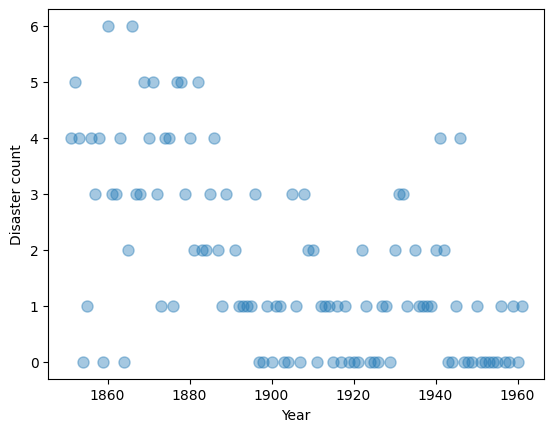

In [ ]:
## Define Data
# fmt: off
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)
# fmt: on
years = np.arange(1851, 1962)

na_bool = np.logical_not(np.isnan(disaster_data))
disaster_data = disaster_data.loc[na_bool]
years = years[na_bool]

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");


In [ ]:
with pm.Model() as disaster_model:

    # Uniform Prior on switchpoint location --> We think it can be anywhere
    # between the minimum and maximum times
    # "testval" = Our guess of where it could be, useful if dataset is small
    switchpoint = pm.DiscreteUniform(
        "switchpoint", lower=years.min(), upper=years.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    # While statement (switchpoint >= years) is false, use early rate
    # if true, use late rate
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    # Data modelled as poisson distribution with the given rate
    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/usr/local/lib/python3.10/dist-packages/pymc/distributions/distribution.py:457: FutureWarning: The `testval` argument is deprecated; use `initval`.
  return super().__new__(cls, name, *args, **kwargs)


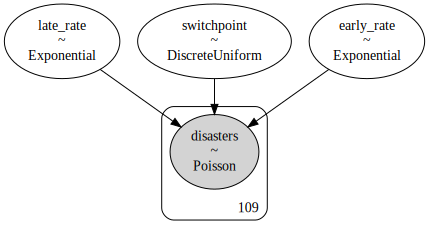

In [ ]:
# Plot the graph for the model
pm.model_to_graphviz(disaster_model)

In [ ]:
# Run inference on the model
with disaster_model:
    disaster_trace = pm.sample()

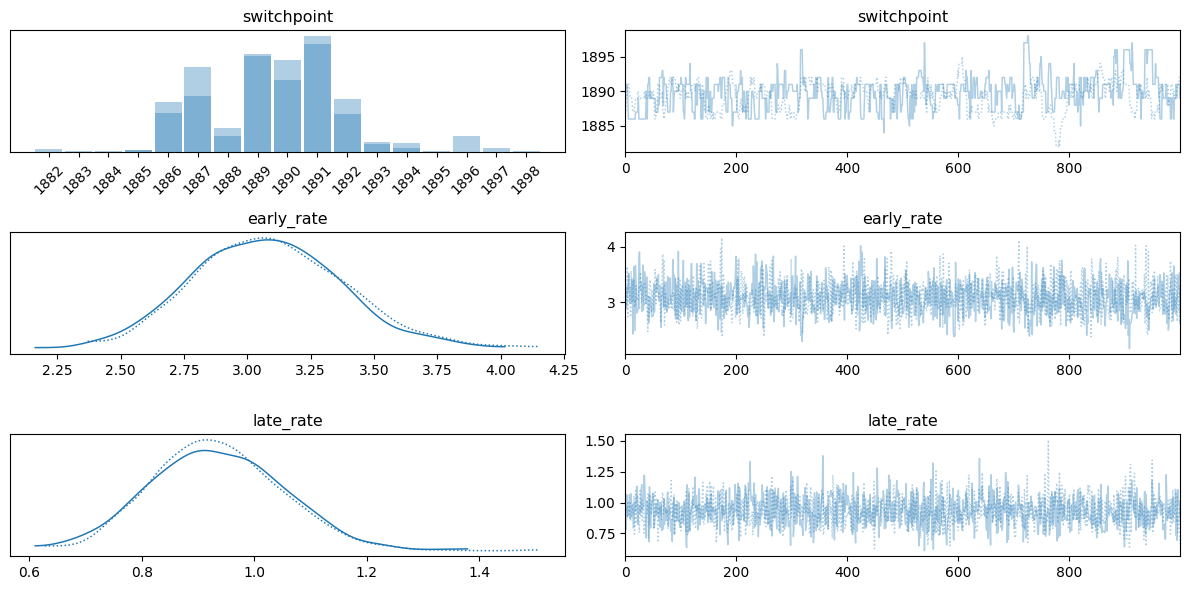

In [ ]:
# Plot inferred distributions
ax = pm.plot_trace(disaster_trace);
plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45);
plt.tight_layout()

In [ ]:
# Sample OBSERVATIONS from the posterior distribution, using the paramters as determined by the trace
with disaster_model:
  disaster_ppc = pm.sample_posterior_predictive(disaster_trace)

In [ ]:
ppc_values = disaster_ppc['posterior_predictive']['disasters']
mean_ppc, std_ppc = np.mean(ppc_values,axis=(0,1)),np.std(ppc_values,axis=(0,1))

disaster_switch_inferred = disaster_trace["posterior"]["switchpoint"]
mean_switch,std_switch = disaster_switch_inferred.mean(), disaster_switch_inferred.std()

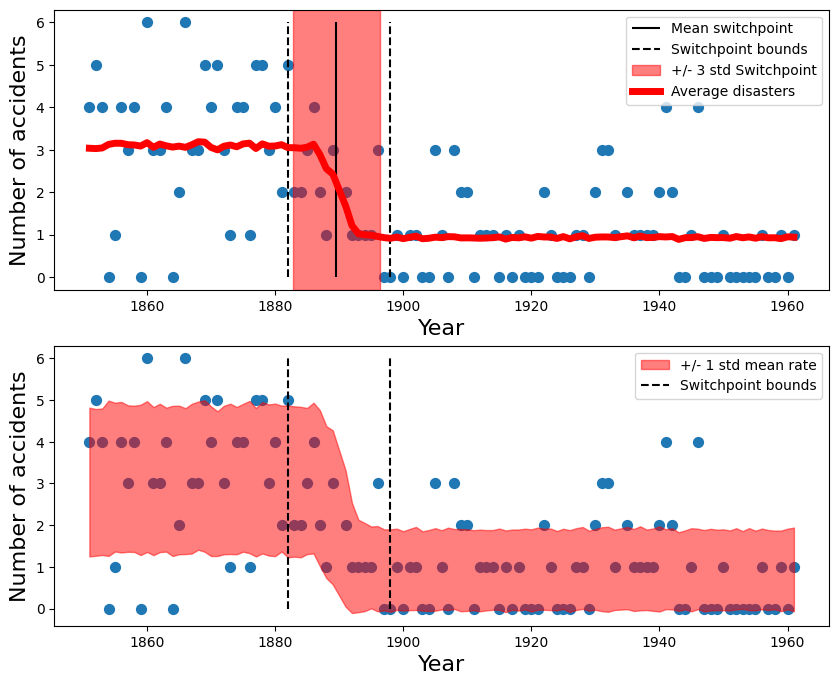

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))

ax[0].scatter(years, disaster_data, marker = ".", s = 200)
ax[0].set_ylabel("Number of accidents", fontsize=16)
ax[0].set_xlabel("Year", fontsize=16)

ax[0].vlines(mean_switch, disaster_data.min(), disaster_data.max(),
           color="k", label = 'Mean switchpoint')

ax[0].vlines(disaster_switch_inferred.min(), disaster_data.min(), disaster_data.max(),
           color="k", linestyles = 'dashed')
ax[0].vlines(disaster_switch_inferred.max(), disaster_data.min(), disaster_data.max(),
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[0].axvspan(mean_switch-3*std_switch, mean_switch+3*std_switch, alpha = 0.5,
            color='r', label = '+/- 3 std Switchpoint')
ax[0].plot(years, mean_ppc, label = 'Average disasters', c='red', lw=5)
ax[0].legend()

ax[1].scatter(years, disaster_data, marker = ".", s = 200)
ax[1].set_ylabel("Number of accidents", fontsize=16)
ax[1].set_xlabel("Year", fontsize=16)
ax[1].fill_between(years, mean_ppc-std_ppc, mean_ppc+std_ppc,
                   label = '+/- 1 std mean rate', color='red', alpha = 0.5)
ax[1].vlines(disaster_switch_inferred.min(), disaster_data.min(), disaster_data.max(),
           color="k", linestyles = 'dashed')
ax[1].vlines(disaster_switch_inferred.max(), disaster_data.min(), disaster_data.max(),
           color="k", label = 'Switchpoint bounds', linestyles = 'dashed')
ax[1].legend()

# === Bernoulli Mixture Emissions ===

In [ ]:
# Define parameters
fit = int(1e5)
samples = 2000

# Generate test spiking data
length = 100
states = 3
trials = 30
idx = np.arange(length)

# Generate transition times
true_tau = np.cumsum(np.random.random((trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[:,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

# Generate state boundaries using transition times
state_inds = np.concatenate([np.zeros((trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

# Generate emission values
n_components = 2
true_lambda = np.random.random((n_components,states))

<ipython-input-12-05ce0e970ff9>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  true_tau = np.vectorize(np.int)(true_tau)
<ipython-input-12-05ce0e970ff9>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

In [ ]:
# Generate "trials" from 2 different mixture components with uneven mixture probabilities
component_inds = np.random.choice(range(n_components), trials, p = [0.3,0.7])
true_r = np.zeros((trials,length))
for trial in range(trials):
    for state in range(states):
        true_r[trial, state_inds[trial,state]:state_inds[trial,state+1]] = \
                    true_lambda[component_inds[trial],state]

# Final spiking data
data_vec = np.random.random(true_r.shape) < true_r

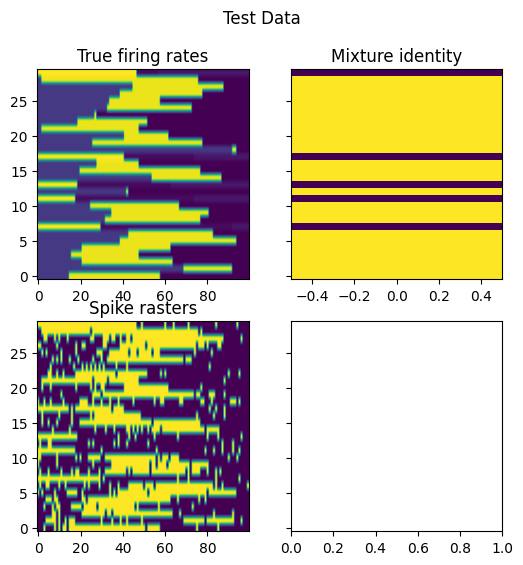

In [ ]:
# Visualize test data
fig,ax = plt.subplots(2,2,figsize=(6,6),sharey=True)
ax[0,1].imshow(component_inds[:,np.newaxis], aspect='auto',origin='lower');
ax[0,0].imshow(true_r,aspect='auto',origin='lower');
ax[1,0].imshow(data_vec,aspect='auto',origin='lower');

fig.suptitle('Test Data');
ax[0,0].set_title('True firing rates');
ax[0,1].set_title('Mixture identity');
ax[1,0].set_title('Spike rasters');

In [ ]:
# Calculate mean emission values to initialize parameters
mean_vals = np.array([np.mean(x,axis=(0,-1)) for x in np.array_split(data_vec,states,axis=-1)]).T

In [ ]:
with pm.Model() as model:
    alpha_w = pm.Gamma('alpha_w',7.5,1,shape = n_components)
    w = pm.Dirichlet('w', a=alpha_w, shape = (trials,n_components))

    alphas = pm.HalfCauchy('alphas',5,shape=(2,3))
    betas = pm.HalfCauchy('betas',5,shape=(2,3))
    clust0_lambda = pm.math.stack([pm.Beta('l00',alphas[0,0], betas[0,0]),
                             pm.Beta('l01',alphas[0,1], betas[0,1]),
                             pm.Beta('l02',alphas[0,2], betas[0,2])])
    clust1_lambda = pm.math.stack([pm.Beta('l10',alphas[1,0], betas[1,0]),
                             pm.Beta('l11',alphas[1,1], betas[1,1]),
                             pm.Beta('l12',alphas[1,2], betas[1,2])])
    lambdas = pm.math.stack([clust0_lambda,clust1_lambda])

In [ ]:
with model:
    #################################################
    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)

    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b,
                         #testval = even_switches,
                         shape = (trials,states-1)).sort(axis=-1)

    tau = pm.Deterministic('tau',
            idx.min() + (idx.max() - idx.min()) * tau_latent)

In [ ]:
with model:
    #################################################

    weight_stack = pm.math.sigmoid(idx[np.newaxis, np.newaxis, :]-tau[:,:,np.newaxis])
    weight_stack_shape = weight_stack.shape.value
    weight_stack = pm.math.concatenate(
        [np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            ),weight_stack],
        axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = pm.math.concatenate(
        [inverse_stack,
         np.ones(
            (weight_stack_shape[0],1,weight_stack_shape[-1])
            )
         ],
        axis=1)
    weight_stack = np.multiply(weight_stack,inverse_stack)

In [ ]:
with model:
    #################################################
    selected_lambdas = pm.math.dot(w,lambdas)[:,:,np.newaxis]
    lambda_ = pm.math.sum(selected_lambdas*weight_stack,axis=1)
    # Add observations
    observation = pm.Bernoulli("obs", lambda_, observed=data_vec)

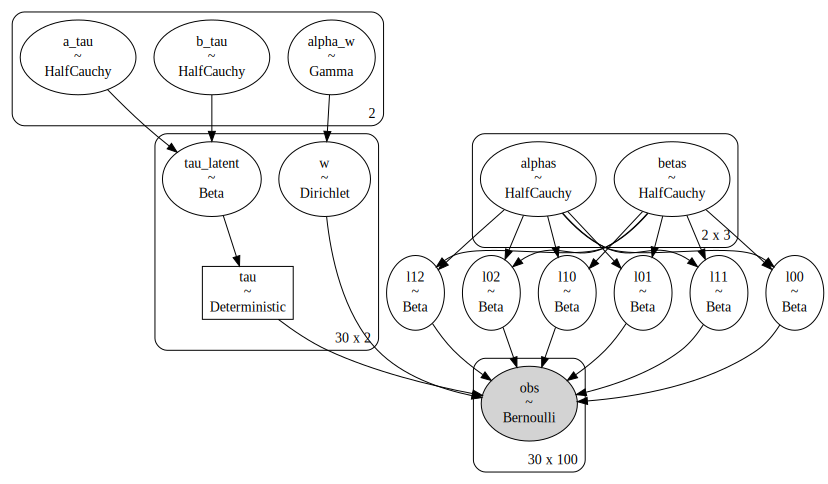

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    trace = pm.sample()

In [ ]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace)

In [ ]:
mean_ppc_obs = np.mean(ppc_trace['posterior_predictive']['obs'],axis=0)

In [ ]:
tau_samples = trace['posterior']['tau']
int_tau = np.vectorize(np.int)(tau_samples)
mode_tau = stats.mode(int_tau,axis=0)[0][0]
hist_tau = np.array([np.histogram(trial, bins = np.arange(20))[0] for trial in int_tau.swapaxes(0,1)])

<ipython-input-31-cb5e669cd44e>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_tau = np.vectorize(np.int)(tau_samples)


In [ ]:
w_samples = trace['posterior']['w'].values
w_samples_long = np.reshape(w_samples,(-1,w_samples.shape[-1]))
mean_w = np.mean(w_samples,axis=(0,1))
#categorical_w = np.argmax(mean_w,axis=(0,-1))

In [ ]:
cat_accuracy_list = [np.sum(categorical_w==component_inds),
                      np.sum((1-categorical_w)==component_inds)]
model_ind = np.int(np.argmax(cat_accuracy_list))
cat_accuracy = cat_accuracy_list[model_ind]

hist_out = np.histogram2d(*w_samples_long.T,bins=50)
diag_vals = np.diag(np.flip(hist_out[0],axis=-1))

components_hist = np.histogram(component_inds,np.arange(3))[0]
components_hist = components_hist/np.max(components_hist)

<ipython-input-38-09b2ff86e917>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  model_ind = np.int(np.argmax(cat_accuracy_list))


In [ ]:
w_samples.shape

(2, 1000, 30, 2)

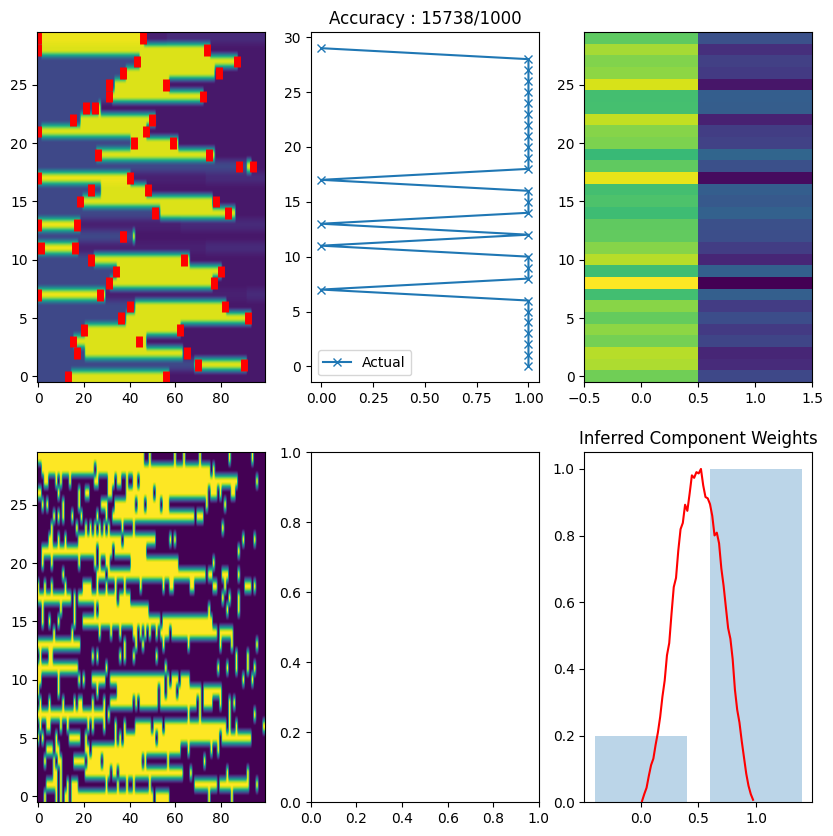

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0,0].imshow(true_r,aspect='auto',origin='lower',vmin=0,vmax=1)
ax[0,1].plot(component_inds, np.arange(trials),'-x',label='Actual')
#ax[0,1].plot(categorical_w, np.arange(trials),'-x', label='Inferred')
ax[0,1].set_title(f'Accuracy : {cat_accuracy}/{categorical_w.shape[0]}')
ax[0,1].legend()
for trial,val in enumerate(mode_tau):
    ax[0,0].vlines(val, trial-0.5,trial+0.5, linewidth = 5, color='red')
ax[1,0].imshow(data_vec,aspect='auto',origin='lower')
#ax[1,1].imshow(mean_ppc_obs,aspect='auto',origin='lower',vmin=0,vmax=1);
ax[0,2].imshow(mean_w,aspect='auto',origin='lower');
ax[1,2].plot(hist_out[1][:-1],diag_vals/np.max(diag_vals),c='r');
ax[1,2].bar([0,1],components_hist, alpha = 0.3);
ax[1,2].set_title('Inferred Component Weights');

In [ ]:
# Plot mixture emissions

# === Dirichlet Process Changepoint ===

In [ ]:
def stick_breaking(beta):
    portion_remaining = pm.math.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

[ 15  45  73 109 113 122 150 165]
[  0  15  45  73 109 113 122 150 165 200]
(10, 9)
(10, 200)


<ipython-input-63-2b086ca86059>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  true_tau = np.vectorize(np.int)(true_tau)
<ipython-input-63-2b086ca86059>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

Text(0, 0.5, 'Neuron # (Channels)')

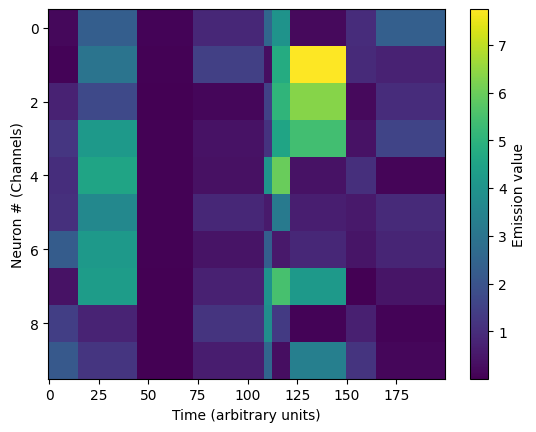

In [ ]:
# Some poisson spiking
length = 200
states = 9
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

nrns = 10
lambda_multipliers = np.random.random(states) * 10
true_lambda = np.random.random((nrns,states))
true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]

print(true_tau)
print(state_inds)
print(true_lambda.shape)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]

plt.imshow(true_r,aspect='auto', interpolation='nearest');plt.colorbar(label = 'Emission value')
plt.xlabel('Time (arbitrary units)')
plt.ylabel("Neuron # (Channels)")

In [ ]:
# Total length of data
length = 200
# Index vector timebins in data
idx = np.arange(length)
# Number of simultaneously recorded neurons a.k.a "channels"
nrns = 10
# Max number of states
changes = 10

with pm.Model() as dpp_model:

    # ===================
    # Emissions Variables
    # ===================
    lambda_latent = pm.Normal('lambda',
                    mu = 0, sigma = 10,
                    shape = (nrns,changes))

    # =====================
    # Changepoint Variables
    # =====================

    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',10,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)

    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)

    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = changes)

    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))

    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])

    # Weight stack to assign lambda's to point in time
    weight_stack = pm.math.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = pm.math.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = pm.math.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)

    # Create timeseries for latent variable (mean emission)
    lambda_ = pm.Deterministic('lambda_',
                               tt.tensordot(
                                   lambda_latent,
                                   weight_stack,
                                   axes=(1,0)
                               )
                              )

    # Likelihood for observations
    observation = pm.Normal("obs", mu = lambda_, sigma = 0.1, observed=true_r)

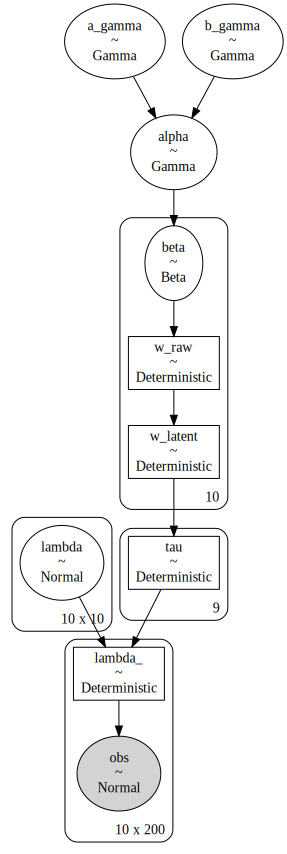

In [ ]:
pm.model_to_graphviz(dpp_model)

In [ ]:
n_chains = 20
with dpp_model:
    dpp_trace = pm.sample(
                        tune = 5000//n_chains,
                        draws = 5000//n_chains,
                        target_accept = 0.95,
                        chains = n_chains)

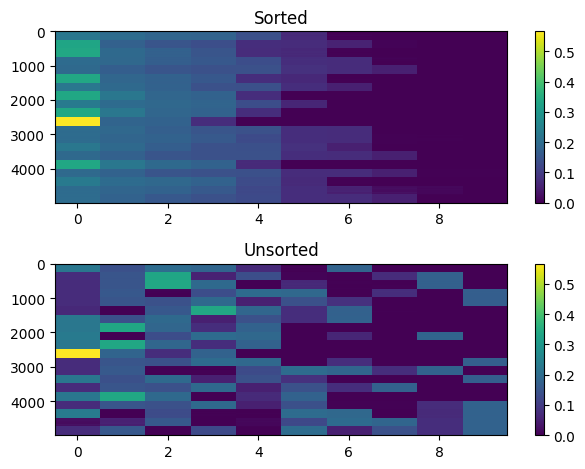

In [ ]:
w_latent_samples = dpp_trace['posterior']['w_latent'].values
cat_w_latent_samples = np.concatenate(w_latent_samples)
sorted_lens = np.sort(cat_w_latent_samples,axis=-1)[:,::-1]
mean_lens = sorted_lens.mean(axis=0)
std_lens = sorted_lens.std(axis=0)

fig,ax = plt.subplots(2,1)
im1 = ax[0].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
im2 = ax[1].imshow(cat_w_latent_samples, interpolation='nearest', aspect= 'auto')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Sorted')
ax[1].set_title('Unsorted')
plt.tight_layout()

In [ ]:
sorted_w_latent = np.stack(np.array_split(np.sort(w_latent_samples,axis=-1)[...,::-1],n_chains,axis=0))
sorted_w_latent = np.squeeze(sorted_w_latent)
mean_sorted = np.mean(sorted_w_latent, axis = 1)

all_state_edges = np.concatenate([[0],true_tau,[length]])
state_durations = np.abs(np.diff(all_state_edges))
sorted_state_durations = np.sort(state_durations / length)[::-1]
shortest_state = sorted_state_durations[-1]

In [ ]:
inds = np.array(list(np.ndindex(mean_sorted.shape)))
state_frame = pd.DataFrame(
                        dict(
                            chains = inds[:,0],
                            states = inds[:,1]+1,
                            dur = mean_sorted.flatten()
                        )
                    )

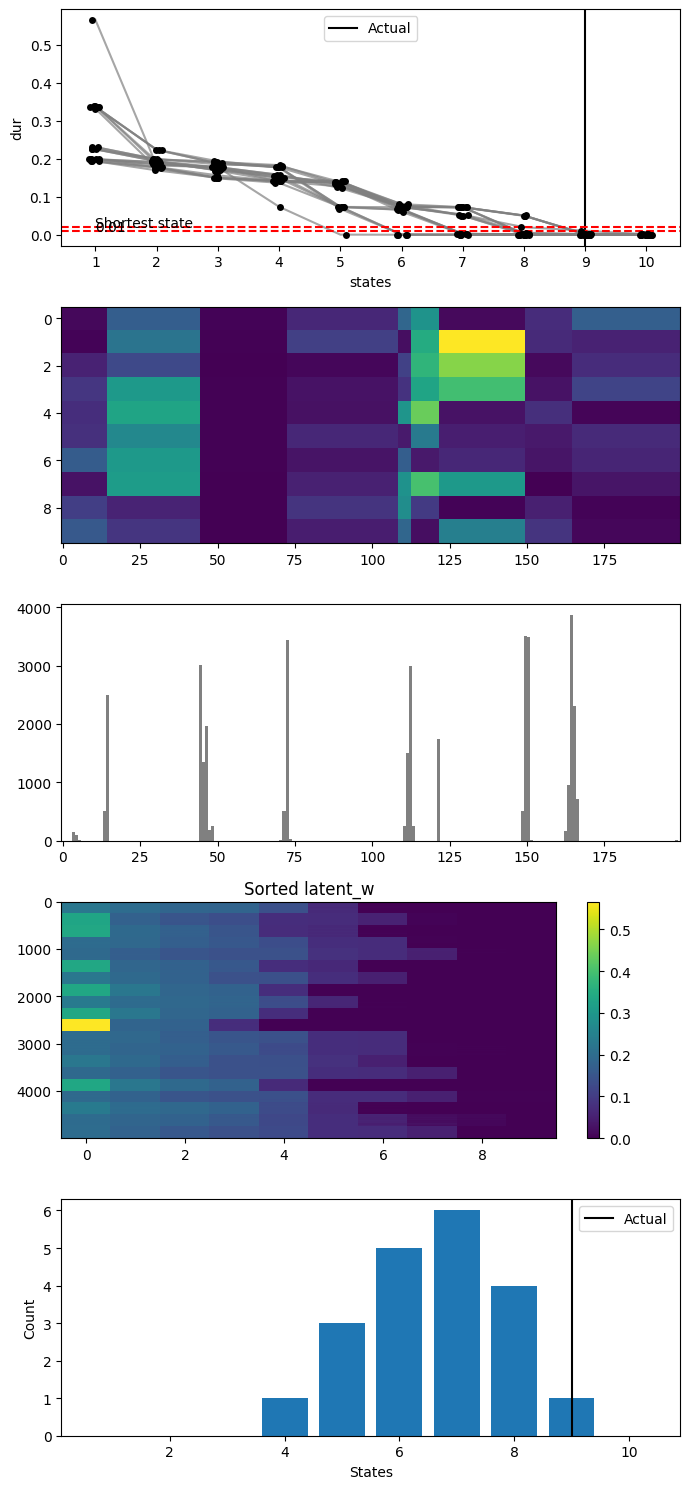

In [ ]:
fig,ax = plt.subplots(5,1, figsize = (7,15))

sns.stripplot(
    data = state_frame,
    x = 'states',
    y = 'dur',
    color = 'k',
    ax = ax[0]
)
ax[0].plot(mean_sorted.T, alpha = 0.7, color = 'grey')

ax[0].axvline(states-1, zorder = -1, color = 'black', label = 'Actual')
ax[0].legend()
ax[0].axhline(shortest_state, color = 'red', linestyle = '--')
ax[0].text(0, shortest_state, 'Shortest state')
ax[0].axhline(0.01, color = 'red', linestyle = '--')
ax[0].text(0, 0.01, '0.01')
# ax[0].axhline(0.05, color = 'red', linestyle = '--')
# ax[0].text(0, 0.05, '0.05')

corrected_transitions = np.cumsum(sorted_w_latent,axis=-1)
tau_samples = dpp_trace['posterior']['tau'].values
ax[1].imshow(true_r,aspect='auto', interpolation = 'nearest')
# for x in tau_samples.T:
#     ax[2].hist(x, bins = np.arange(length), c = 'k')
ax[2].hist(tau_samples.flatten(), bins = np.arange(length), color = 'grey')
ax[2].sharex(ax[1])

im1 = ax[3].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
ax[3].set_title('Sorted latent_w')
fig.colorbar(im1, ax=ax[3])
plt.tight_layout()

max_state_per_chain = state_frame.loc[state_frame.dur > 0.01].groupby('chains').max()
max_state_counts = max_state_per_chain.groupby('states').count()
state_vec = np.arange(1,changes+1)
counts = [max_state_counts.loc[x].values[0] if x in max_state_counts.index else 0 for x in state_vec ]
ax[4].axvline(states, zorder = 2, color = 'black', label = 'Actual')
ax[4].legend()
ax[4].bar(state_vec, counts)
ax[4].set_xlabel("States")
ax[4].set_ylabel('Count')

plt.tight_layout()
